# 01_train_LSTM.ipynb

Bu notebook, LSTM modeli eğitmek ve kaydetmek için kullanılır.

In [36]:
import os, sys

# proje kök dizinini; notebooks/ içinde olduğumuz için bir üst klasör olarak ayarlanacak
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# ardından bunu system path'ine ekleyeceğiz
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [37]:
from src.data_prep import download_data, clean_data, scale_data, create_sequences, save_csvs
from src.model import build_lstm, train_and_save
import pandas as pd
import numpy as np
import joblib

## 1. Veri Hazırlama

In [38]:
# indirilecek veri için ayarlamalar
symbol = "AAPL"
start, end = "2010-01-01", "2025-07-09"

# veriyi indirme ve model eğitimi için hazırlama
# fonksiyonların açıklamaları src/data_prep.py içinde var
df = download_data(symbol, start, end)
df = clean_data(df)
save_csvs(df, symbol, sample_frac=0.01)

# eğitim için tarih sınırı
train_end_date = "2023-12-31"
train_df = df.loc[:train_end_date]

scaled_data, scaler = scale_data(train_df)
seq_length = 60
X_train, y_train = create_sequences(scaled_data, seq_length)

# test kısmı için scaler'i kaydet
scaler_path = os.path.join(project_root, "data", "scaler.save")
joblib.dump(scaler, scaler_path)
print(f"Scaler kaydedildi: {scaler_path}")

print(f"Train shape: {X_train.shape}")

Raw veri kaydedildi: ../data/raw/AAPL_full.csv
Sample veri kaydedildi: ../data/sample/AAPL_sample.csv
Scaler kaydedildi: /home/outro/vscode_projects/borsa-aslani/data/scaler.save
Train shape: (3462, 60, 5)


/home/outro/vscode_projects/borsa-aslani/src/data_prep.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, progress=False)


## 2. Model Eğitimi

In [39]:
# model için hiper-parametrelerin belirlenmesi (burada models altında farklı hiper parametreler için modeller var)
units = 64
dropout = 0.2
lr = 0.001

# model oluşturma
model = build_lstm((seq_length, X_train.shape[2]), units, dropout)

# model eğitiminin yapılması ve "/models" altına kaydedilmesi
save_path = f"../models/lstm_seq{seq_length}_units{units}_dr{dropout}_lr{lr}_{pd.Timestamp.now().strftime('%Y%m%d-%H%M')}.h5"
history = train_and_save(model, X_train, y_train, save_path, lr)

Epoch 1/100


/home/outro/vscode_projects/borsa-aslani/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0247 - val_loss: 9.0592e-04
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - val_loss: 8.1966e-04
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0010 - val_loss: 9.0108e-04
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.7312e-04 - val_loss: 6.6688e-04
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.8732e-04 - val_loss: 6.3600e-04
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.9210e-04 - val_loss: 0.0012
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.5759e-04 - val_loss: 7.7270e-04
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.0952e-04 - val_loss: 0.0011
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6813e-04 - val_loss: 6.4401e-04
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.4399e-04 - val_loss: 6.9701e-04
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.5504e-04 - val_loss: 5.7896e

## 3. Eğitim Sonuçları

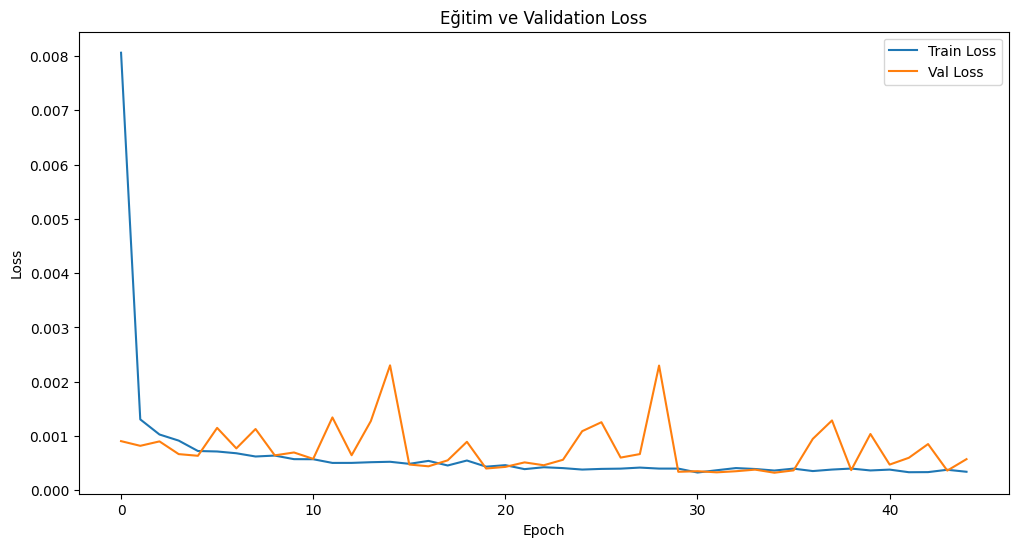

In [40]:
import matplotlib.pyplot as plt

# eğitim sonuçlarının (test değil) gösterimi
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Eğitim ve Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()